In [1]:
from pyteomics import mzxml
from pyteomics import mgf
from spectrum_alignment import *
import numpy as np
import pandas as pd
import subprocess
import os
import glob
import requests
import json
import time
import csv
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import jaccard_score

### inputs

mgf_folder = "./NPOmix_mgf_spectra/" # this folder needs to contain all mgf files (MS/MS data) to be tested
LCMS_folder = "/Volumes/TFL210426/podp_LCMS_round5/" # this folder needs to contain all mz(X)ML files in the training set
ena_df_file = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/temp_files/ena_dict-round3-210315.csv" # this file contains the correspondance between ENA codes
input_bigscape_net = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/bigscape_outputs_210427/bigscape_all_c030.txt" # this file contains the BiG-SCAPE scores for all BGCs from the 1,040 genomes
antismash_folder = "/Volumes/TFL210426/ming_output_round4/antismash/" # this folder needs to contain all antismash files (annotated genomes) to be used in the training set
merged_ispec_mat_file = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/outputs/mass-affinity_df-NPOmix1.0-TFL210811.txt" # (OPTIONAL) if you already ran the step to obtain the merged_ispec_mat, you can skip this time consuming step by inputting this file
results_folder = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/main_code_results/" # folder where the results will be saved

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
    
### Obtaining library names

def get_ms2df(file_name, speclist, pmztol=0.1, fragtol=0.1):
    rt = []
    mz = []
    inten = []
    prec_mz = []
    scan_num = []
    scores = []
    specids = []
    pmlist = []
    for spec in speclist:
        for k,v in spec.items():
            pmlist.append(v[0])
    pmlist = np.array(pmlist)
    with mzxml.read(file_name) as reader:
        for spectrum in reader:
                if spectrum['msLevel'] == 2:
                    p_mz = spectrum['precursorMz'][0].get('precursorMz')
                    loc = np.where(abs(pmlist-p_mz) < pmztol)[0]
                    if len(loc):
                        for i in loc:
                            qmz = spectrum['m/z array']
                            qint = spectrum['intensity array']
                            qspec = list(zip(qmz, qint))
                            pm1, spec1 = list(speclist[i].values())[0]
                            specid = list(speclist[i].keys())[0]
                            score = score_alignment(spec1, qspec, pm1, p_mz, fragtol)[0]
                            if score>0:
                                lqmz = len(qmz)
                                scan_num.extend([spectrum['num']] * lqmz)
                                rt.extend([spectrum['retentionTime']] * lqmz)
                                mz.extend(qmz)
                                inten.extend(qint)
                                prec_mz.extend([p_mz] * lqmz)
                                scores.extend([score] * lqmz)
                                specids.extend([specid] * lqmz)

    ms2_data = pd.DataFrame(
            {'prec_mz': prec_mz,
             'mz': mz,
             'inten': inten,
             'rt': rt,
             'scan_num': scan_num,
             'specids': specids,
             'scores': scores
            })
    return ms2_data

def get_library(lib, peaks=False):
    base_url = "gnps.ucsd.edu"
    if peaks:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib + '&showpeaks=true'
    else:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib
    json_obj = json.loads(requests.get(datasets_url).text)
    return json_obj['spectra']

### Creating a list of reference spectra from mgf files stored in their specified directory

def select_mgf(mgf_folder):
    fmgf = [x for x in os.listdir(mgf_folder) if '.mgf' in x]
    speclist = []
    for i in range(len(fmgf)):
        with mgf.MGF('%s%s' % (mgf_folder,fmgf[i])) as reader: 
            for spectrum in reader:
                speclist.append({fmgf[i][:18] : [spectrum['params']['pepmass'][0], 
                                                list(zip(spectrum['m/z array'], spectrum['intensity array']))]
                                } 
                )
    return fmgf,speclist

### Comparing mgfs to our downloaded database of 1,040 paired samples and filtering for metabolites found in the metabolomes
### This code generates a fingerprint matrix to be used in the testing stage

def get_mxlist(speclist,LCMS_folder):
    dirlist = glob.glob('%s*'%LCMS_folder)
    mxlist,excluded_list = [],[]
    for dr in dirlist:
        print(dr)
        try:
            ms2_data = get_ms2df(dr, speclist)
            mxlist.append(ms2_data.loc[ms2_data.groupby(['scan_num'])['scores'].idxmax()])
        except:
            excluded_list.append(dr)
    return mxlist,excluded_list

def get_filt_specn(speclist,LCMS_folder,fmgf):
    mxlist,excluded_list = get_mxlist(speclist,LCMS_folder)
    refn = [x[:-4] for x in fmgf]
    specn = os.listdir(LCMS_folder)
    clean_excluded_list = []
    for item in excluded_list:
        clean_excluded_list.append(os.path.basename(item))
    filt_specn = []
    for item in specn:
        if '._' not in item:
            if item not in clean_excluded_list:
                filt_specn.append(item)
    return filt_specn,mxlist,refn

def get_ispec_mat(speclist,LCMS_folder,fmgf):
    filt_specn,mxlist,refn = get_filt_specn(speclist,LCMS_folder,fmgf)
    ispec_mat = pd.DataFrame(0, index=refn, columns=filt_specn)
    for i in range(len(filt_specn)):
        mtmp = mxlist[i].loc[mxlist[i].groupby(['specids'])['scores'].idxmax()]
        ispec_mat.loc[mtmp['specids'], filt_specn[i]] = mtmp['scores'].tolist()
    (ispec_mat>0.7).sum().sum()
    ispec_mat = ispec_mat[(ispec_mat.T != 0).any()]
    ispec_mat = ispec_mat.fillna(0)
    return ispec_mat

def get_merged_ispec_mat(ispec_mat):
    ispec_mat_trans = ispec_mat.T
    processed_list = []
    merged_ispec_mat = pd.DataFrame()
    for i,r in ispec_mat_trans.iterrows():
        strain = i.split('.')[0]
        if strain not in processed_list:
            processed_list.append(strain)
            ispec_temp = ispec_mat_trans[ispec_mat_trans.index.map(lambda x: strain in x)]
            if len(ispec_temp) == 1:
                merged_ispec_mat[strain] = ispec_temp.loc[ispec_temp.index[0], :].values.tolist()
            else:
                merged_ispec_mat[strain] = list(ispec_temp.max(axis=0))
    merged_ispec_mat.index = list(ispec_mat.index)
    return merged_ispec_mat

def renaming_merged_ispec_mat(ena_df_file,merged_ispec_mat):
    ena_df = pd.read_csv(ena_df_file,sep=',',names=['ERR_code','ERXS_code'])
    ena_dict = dict(zip(ena_df['ERXS_code'],ena_df['ERR_code']))
    new_cols_ispec = []
    for item in merged_ispec_mat.columns:
        if 'ERS' in item or 'ERX' in item:
            new_cols_ispec.append(ena_dict[item])
        else:
            new_cols_ispec.append(item)
    merged_ispec_mat.columns = new_cols_ispec
    return merged_ispec_mat

### obtaining bigscape dataframe and bigscape dictionary

def parse_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = parse_bigscape_df(input_file)
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict

def get_bigscape_df(ena_df_file,input_bigscape_net):
    ena_df = pd.read_csv(ena_df_file,sep=',',names=['ERR_code','ERXS_code'])
    ena_dict = dict(zip(ena_df['ERXS_code'],ena_df['ERR_code']))
    bigscape_df,bigscape_dict = main_get_families(input_bigscape_net)
    bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]
    return bigscape_df,bigscape_dict

### renaming bigscape dataframe and bigscape dictionary

def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file and '._' not in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

def get_bigscape_dict2(name_dict,bigscape_dict):
    bigscape_dict2 = defaultdict(list)
    for key in bigscape_dict:
        for value in bigscape_dict[key]:
            if 'BGC' in value:
                bigscape_dict2[key].append(value)
            else:
                if 'ERR' in name_dict[value]:
                    new_ERR_name = name_dict[value].split('_')[0] + '.' + name_dict[value].split('.')[1]
                    bigscape_dict2[key].append(new_ERR_name)
                else:
                    bigscape_dict2[key].append(name_dict[value])
    return bigscape_dict2

def rename_bigscape_df(antismash_folder,bigscape_df,bigscape_dict):
    gbk_list,new_name_list = parse_gbk_list([antismash_folder])
    name_dict = dict(zip(gbk_list,new_name_list))
    bigscape_dict2 = get_bigscape_dict2(name_dict,bigscape_dict)
    new_col1, new_col2 = [],[]
    for i,r in bigscape_df.iterrows():
        if 'BGC' in bigscape_df['Clustername_1'].loc[i]:
            new_col1.append(bigscape_df['Clustername_1'].loc[i])
        else:
            new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
        if 'BGC' in bigscape_df['Clustername_2'].loc[i]:
            new_col2.append(bigscape_df['Clustername_2'].loc[i])
        else:
            new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    bigscape_df['Clustername_1'] = new_col1
    bigscape_df['Clustername_2'] = new_col2
    return bigscape_df,bigscape_dict2

def save_bigscape_dict(bigscape_dict2,results_folder):
    w = csv.writer(open("%sbigscape_dict2-NPOmix1.0_main-TFL211102.txt"%results_folder, "w"))
    for key, val in bigscape_dict2.items():
        w.writerow([key, val])
        
### obtaining the affinity dataframe (BGC fingerprints)

def get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bigscape_bgcs):
    training_df = pd.DataFrame(columns=strain_list, index=range(0,len(bigscape_bgcs)))
    index_row = 0
    row_names = []
    for gcf in bigscape_dict:
        for cluster in bigscape_dict[gcf]:
            row_names.append(cluster)
            temp_dict = {}
            self = cluster.split(".")[0]
            temp_dict[self] = [1]
            temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                                  bigscape_df.Clustername_2.str.contains(cluster)]
            for i,r in temp_df.iterrows():
                if temp_df.Clustername_1.loc[i] == cluster:
                    target = temp_df.Clustername_2.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict:
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
                else:
                    target = temp_df.Clustername_1.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict.keys():
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            for key in temp_dict:
                if len(temp_dict[key]) > 1:
                    new_value = max(temp_dict[key])
                    temp_dict[key] = new_value
                else:
                    temp_dict[key] = temp_dict[key][0]
            temp_dict["label"] = gcf
            training_df.loc[index_row] = pd.Series(temp_dict)
            index_row += 1
    training_df.fillna(0,inplace=True)
    return training_df,row_names

def get_strain_list(bigscape_df):
    bgcs_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
    strain_list = []
    for item in bgcs_list:
        if "BGC" not in item:
            strain_list.append(item.split(".")[0])
    strain_list = list(np.unique(strain_list))
    strain_list.append("label")
    return strain_list,bgcs_list

def renaming_affinity_df(affinity_df):
    new_affinity_names = []
    for item in list(affinity_df.columns):
        if '_contigs' in item:
            new_affinity_names.append(item.split('_')[0])
        else:
            new_affinity_names.append(item)
    affinity_df.columns = new_affinity_names
    return affinity_df

### obtaining training dataframe

def get_networked_cols(merged_ispec_mat,affinity_df):
    networked_cols = []
    for item in merged_ispec_mat.columns:
        if item in affinity_df.columns:
            networked_cols.append(item)
    return networked_cols

def get_training_df(affinity_df,networked_cols,results_folder):
    training_df = affinity_df[networked_cols]
    label_col = affinity_df['label']
    training_df = training_df[(training_df.T != 0).any()]
    filt_label_col = []
    for n,item in enumerate(label_col):
        if n in training_df.index:
            filt_label_col.append(item)
    training_df['label'] = filt_label_col
    training_df = training_df.sort_index(axis=1)
    training_df = training_df.reset_index(drop=True)
    training_df.to_csv("%straining_df-NPOmix1.0_main-TFL211102.txt"%results_folder,sep="\t",index_label=False)
    return training_df

### obtaining testing dataframe

def get_testing_df(merged_ispec_mat,networked_cols,results_folder):
    testing_df = merged_ispec_mat[networked_cols]
    testing_df = testing_df.sort_index(axis=1)
    testing_df = testing_df[testing_df > 0.7].replace(np.nan,0)
    testing_df = testing_df[(testing_df.T != 0).any()]
    testing_df.to_csv("%stesting_df-NPOmix1.0_main-TFL211102.txt"%results_folder,sep="\t",index_label=False)
    return testing_df

### running machine learning k-nearest neighbors and obtaining final output

def running_knn(training_df,testing_df):
    X_div = training_df.drop("label", axis=1)
    y_div = training_df["label"]
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_div,y_div)
    distances, indices = nbrs.kneighbors(testing_df)
    y_div = y_div.reset_index(drop=True)
    neighbors_array = []
    for item in indices:
        candidate_list = []
        for i in range(3):
            candidate_list.append(y_div[item[i]])
        neighbors_array.append(candidate_list)
    neighbors_array = np.asarray(neighbors_array)
    return neighbors_array
        
def get_binary(fingerprint):
    new_row = []
    for index,item in enumerate(fingerprint):
        if item != 0:
            new_row.append(1)
        else:
            new_row.append(0)
    fingerprint = new_row
    return fingerprint
    
def get_final_df(training_df,testing_df,neighbors_array,results_folder):
    final_df = pd.DataFrame(columns=('metabolite_ID','predicted_GCFs','max_jaccard'))
    for i,ccms_id in enumerate(testing_df.index):
        jaccard_scores = []
        for j in range(0,len(neighbors_array[i])):
            query_bgc = neighbors_array[i][j]
            bgc_fp = training_df[training_df['label'] == query_bgc].iloc[0]
            bgc_fp = bgc_fp.drop("label")
            ms_fp = testing_df.loc[ccms_id]
            bgc_binary = get_binary(bgc_fp)
            ms_binary = get_binary(ms_fp)
            jaccard_scores.append(jaccard_score(bgc_binary,ms_binary))
        max_jaccard = round(max(jaccard_scores),2)
        final_df.loc[i] = ccms_id,neighbors_array[i],max_jaccard
    final_df.to_csv("%sfinal_df-NPOmix1.0_main-TFL211102.txt"%results_folder,sep="\t",index_label=False)
    return final_df

def run_main(mgf_folder,merged_ispec_mat_file,LCMS_folder,ena_df_file,input_bigscape_net,antismash_folder,results_folder):
    start = time.time()
    libnames = pd.DataFrame(get_library('all'))
    fmgf,speclist = select_mgf(mgf_folder)
    if os.path.isfile(merged_ispec_mat_file):
        merged_ispec_mat = pd.read_csv(merged_ispec_mat_file, sep='\t')
    else:
        ispec_mat = get_ispec_mat(speclist,LCMS_folder,fmgf)
        merged_ispec_mat = get_merged_ispec_mat(ispec_mat)
        merged_ispec_mat.to_csv("%smass-affinity_df-NPOmix1.0_main-TFL211102.txt"%results_folder,sep="\t",index_label=False)
    merged_ispec_mat = renaming_merged_ispec_mat(ena_df_file,merged_ispec_mat)
    bigscape_df,bigscape_dict = get_bigscape_df(ena_df_file,input_bigscape_net)
    bigscape_df,bigscape_dict2 = rename_bigscape_df(antismash_folder,bigscape_df,bigscape_dict)
    save_bigscape_dict(bigscape_dict2,results_folder)
    strain_list,bgcs_list = get_strain_list(bigscape_df)
    affinity_df,affinity_bgcs = get_pre_training_df(bigscape_df,bigscape_dict2,strain_list,bgcs_list)
    affinity_df = renaming_affinity_df(affinity_df)
    networked_cols = get_networked_cols(merged_ispec_mat,affinity_df)
    training_df = get_training_df(affinity_df,networked_cols,results_folder)
    testing_df = get_testing_df(merged_ispec_mat,networked_cols,results_folder)
    neighbors_array = running_knn(training_df,testing_df)
    final_df = get_final_df(training_df,testing_df,neighbors_array,results_folder)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    return final_df

final_df = run_main(mgf_folder,merged_ispec_mat_file,LCMS_folder,ena_df_file,input_bigscape_net,antismash_folder,results_folder)

00:20:37.34


In [2]:
final_df

,metabolite_ID,predicted_GCFs,max_jaccard
0,CCMSLIB00000070259,"[GCF601, GCF606, GCF596]",0.50
1,CCMSLIB00000070265,"[GCF627, GCF612, GCF627]",0.50
2,CCMSLIB00004679300,"[GCF465, GCF445, GCF450]",1.00
3,CCMSLIB00004681487,"[GCF180, GCF476, GCF476]",1.00
4,CCMSLIB00005436037,"[GCF102, GCF102, GCF102]",0.14
5,CCMSLIB00004681486,"[GCF180, GCF476, GCF476]",1.00
6,CCMSLIB00005464638,"[GCF638, GCF579, GCF637]",0.33
7,CCMSLIB00000070258,"[GCF601, GCF606, GCF596]",0.50
8,CCMSLIB00004692003,"[GCF533, GCF525, GCF536]",0.03
9,CCMSLIB00000070266,"[GCF627, GCF612, GCF627]",0.50


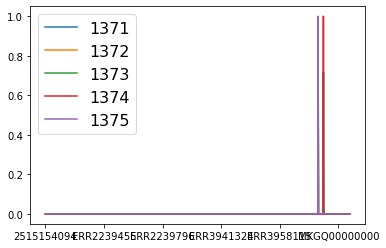

In [3]:
training_df = pd.read_csv("%straining_df-NPOmix1.0_main-TFL211102.txt"%results_folder,sep="\t")
gcf_subset1 = training_df[training_df['label'] == 'GCF229'].T
gcf_subset1 = gcf_subset1.drop('label')
gcf_subset1.plot().legend(loc=2, prop={'size': 16})

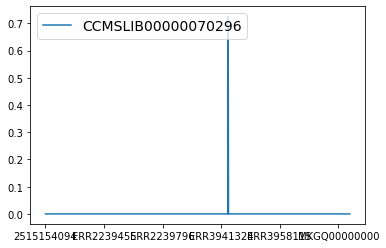

In [4]:
testing_df = pd.read_csv("%stesting_df-NPOmix1.0_main-TFL211102.txt"%results_folder,sep="\t")
mf_subset1 = testing_df.loc['CCMSLIB00000070296'].T
mf_subset1.plot().legend(loc=2, prop={'size': 14})